### Part 1. Data Acquisition & Preprocessing
#### Staring with incorperating the dataset

In [1]:
%pip install kaggle -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing all neccessary frameworks

import numpy as np
import torch


from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

%load_ext cudf.pandas
import pandas as pd
from cuml.manifold import UMAP
from cuml.cluster import hdbscan
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold

In [3]:
%%bash
# Downloading the dataset from Kaggle

export KAGGLE_USERNAME=orranereid
export KAGGLE_KEY=395c5483c47968f4a9e8ea5ac326f64f

#kaggle datasets download -d elvinrustam/books-dataset --unzip

# Preproccessing Data Steps.

**Data Sources**

From Kaggle, we were able to use a Book Dataset with over 100,000 observations. It includes multiple features such as authors, genres, titles, & date of publication.

In [4]:
# Extracting the info from the CSV fiel
gb_md = pd.read_csv('BooksDataset.csv')

In [5]:
# Here we are printing the original data from the csv
gb_md

,Title,Authors,Description,Category,Publisher,Publish Date,Price
0,Goat Brothers,"By Colton, Larry",NaN,"History , General",Doubleday,"Friday, January 1, 1993",Price Starting at $8.79
1,The Missing Person,"By Grumbach, Doris",NaN,"Fiction , General",Putnam Pub Group,"Sunday, March 1, 1981",Price Starting at $4.99
2,Don't Eat Your Heart Out Cookbook,"By Piscatella, Joseph C.",NaN,"Cooking , Reference",Workman Pub Co,"Thursday, September 1, 1983",Price Starting at $4.99
3,When Your Corporate Umbrella Begins to Leak: A...,"By Davis, Paul D.",NaN,NaN,Natl Pr Books,"Monday, April 1, 1991",Price Starting at $4.99
4,Amy Spangler's Breastfeeding : A Parent's Guide,"By Spangler, Amy",NaN,NaN,Amy Spangler,"Saturday, February 1, 1997",Price Starting at $5.32
...,...,...,...,...,...,...,...
103077,Build 3 Super Serving Carts,By Chuck Hampton,NaN,NaN,ENDesigns Inc.,"Wednesday, January 1, 1992",Price Starting at $9.97
103078,My Land of Israel,"By Nover, Elizabeth Z.",NaN,"Juvenile Nonfiction , People & Places , Middl...",Behrman House,"Friday, May 1, 1987",Price Starting at $4.99
103079,Tongues: To Speak or Not to Speak,By Donald W. Burdick,NaN,NaN,Moody Press,"Wednesday, January 1, 1969",Price Starting at $5.29
103080,If I'm in charge here why is everybody laughing?,"By Campbell, David P.",NaN,NaN,Argus Communications,"Tuesday, January 1, 1980",Price Starting at $4.99


**Data Cleaning and Preprocessing**

In this step, we will remove any noisy data with inconsistencies and missing values. Then, we will modify our data by applying tokenization techniques.

In [6]:
# Dropping all observations with missing values
gb_md = gb_md.dropna()

# Now we will be dropping features that are irrelevant for us
gb_md = gb_md.drop(columns=['Price', 'Publisher'])


In [7]:
# Modifying the values in Publish Date to only keep the year
gb_md['Publish Date'] = gb_md['Publish Date'].str.slice(-4)

# Removing the value 'General' from the 'Categories' feature in order to avoid bad clusterings
gb_md['Category'] = gb_md['Category'].str.replace('General', '', regex=False)
gb_md['Category'] = gb_md['Category'].str.strip()
gb_md = gb_md[gb_md['Category'] != '']
gb_md['Category'] = gb_md['Category'].str.rstrip(',')

# Removing "By" in the Authors Column
gb_md['Authors'] = gb_md['Authors'].str.replace('^By ', '', regex=True)


In [8]:
# Demonstrating the first five observations of our "clean" data
gb_md.head()

,Title,Authors,Description,Category,Publish Date
7,Journey Through Heartsongs,"Stepanek, Mattie J. T.",Collects poems written by the eleven-year-old ...,Poetry,2001
8,In Search of Melancholy Baby,"Aksyonov, Vassily, Heim, Michael Henry, and Bo...",The Russian author offers an affectionate chro...,Biography & Autobiography,1987
10,The Dieter's Guide to Weight Loss During Sex,"Smith, Richard","A humor classic, this tongue-in-cheek diet pla...","Health & Fitness , Diet & Nutrition , Diets",1978
11,Germs : Biological Weapons and America's Secre...,"Miller, Judith, Engelberg, Stephen, and Broad,...","Deadly germs sprayed in shopping malls, bomb-l...","Technology & Engineering , Military Science",2001
13,The Good Book: Reading the Bible with Mind and...,"Gomes, Peter J.","""The Bible and the social and moral consequenc...","Religion , Biblical Biography",1998


In [9]:
df = gb_md[52000:65000]

In [10]:
df.head()

,Title,Authors,Description,Category,Publish Date
81173,Pillsbury: Best Muffins and Quick Breads: Favo...,Pillsbury Company,The latest addition to the best-selling cookin...,Cooking,1999
81175,Ross's Gap,"Wisler, G. Clifton",Returning home from the Civil War to reclaim h...,"Fiction , Westerns",1999
81176,"Across the Nightingale Floor, Episode 1: The S...","Hearn, Lian","In a novel set in ancient Japan, the first vol...","Young Adult Fiction , Historical , Asia",2005
81178,Ideas for Great Bathrooms,Sunset Books (EDT),Shows and describes some contemporary bathroom...,"House & Home , Remodeling & Renovation",1999
81179,Stanley and the Magic Lamp,"Bjorkman, Steve (ILT) and Brown, Jeff",The Lambchop family has just about recovered f...,Juvenile Fiction,1996


In [11]:
#Combining the columns description + category which should capture semantics of genre and their summaries
text_data = df['Description'] + ": " + df['Category']

# Initializing our tokenizer from the transformers model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# Also initializing our pre-trained LLM --> BERT
book_model = AutoModel.from_pretrained("bert-base-uncased")

In [12]:
print(torch.cuda.is_available())

True


In [13]:
book_model = book_model.to('cuda')

def get_embeddings_for_chunk(chunk):
    tokenized_inputs = tokenizer(
        chunk,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=512  # Ensure truncation for long texts
    ).to('cuda')  # Move to GPU
    outputs = book_model(**tokenized_inputs)
    return outputs.pooler_output.detach().cpu().numpy()  # Move to CPU before converting to numpy


In [14]:
# Define batch size
batch_size = 24  # Adjust based on available memory

# Process dataset in chunks to avoid memory overload
num_chunks = len(df) // batch_size + 1  # Total chunks based on batch size
all_embeddings = []
for i in range(num_chunks):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(df))

    # Retry mechanism for out-of-memory
    while True:
        try:
            chunk = text_data[start_idx:end_idx].tolist()
            embeddings_chunk = get_embeddings_for_chunk(chunk)
            if i % 10 == 0 or num_chunks - i < 5:
                print(f'Chunk {i} of {num_chunks}')
                print(f'Embedding Chunk Shape: {embeddings_chunk.shape}')
            break
        except RuntimeError as e:
            if "out of memory" in str(e):
                batch_size //= 2  # Halve the batch size
                torch.cuda.empty_cache()  # Clear GPU memory
            else:
                raise e
    all_embeddings.append(embeddings_chunk)
    


# Combine all chunks into a single list of embeddings
all_embeddings = np.vstack(all_embeddings)

# Normalize the embeddings to ensure consistent similarity scores
normalized_embeddings = normalize(all_embeddings)

Chunk 0 of 542
Embedding Chunk Shape: (24, 768)
Chunk 10 of 542
Embedding Chunk Shape: (24, 768)
Chunk 20 of 542
Embedding Chunk Shape: (24, 768)
Chunk 30 of 542
Embedding Chunk Shape: (24, 768)
Chunk 40 of 542
Embedding Chunk Shape: (24, 768)
Chunk 50 of 542
Embedding Chunk Shape: (24, 768)
Chunk 60 of 542
Embedding Chunk Shape: (24, 768)
Chunk 70 of 542
Embedding Chunk Shape: (24, 768)
Chunk 80 of 542
Embedding Chunk Shape: (24, 768)
Chunk 90 of 542
Embedding Chunk Shape: (24, 768)
Chunk 100 of 542
Embedding Chunk Shape: (24, 768)
Chunk 110 of 542
Embedding Chunk Shape: (24, 768)
Chunk 120 of 542
Embedding Chunk Shape: (24, 768)
Chunk 130 of 542
Embedding Chunk Shape: (24, 768)
Chunk 140 of 542
Embedding Chunk Shape: (24, 768)
Chunk 150 of 542
Embedding Chunk Shape: (24, 768)
Chunk 160 of 542
Embedding Chunk Shape: (24, 768)
Chunk 170 of 542
Embedding Chunk Shape: (24, 768)
Chunk 180 of 542
Embedding Chunk Shape: (24, 768)
Chunk 190 of 542
Embedding Chunk Shape: (24, 768)
Chunk 200 o

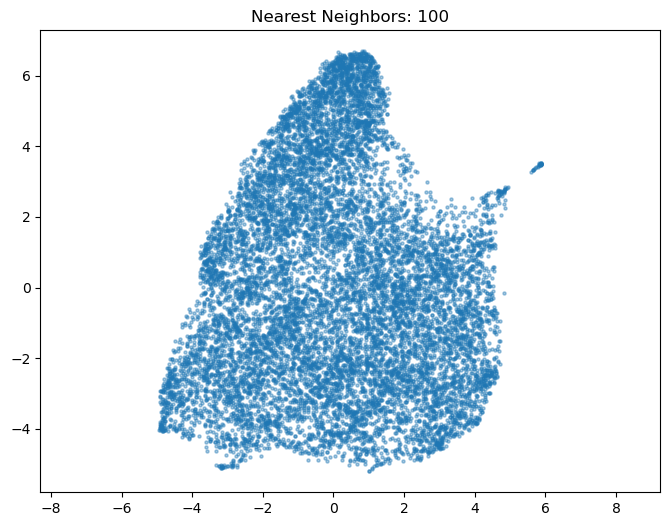

In [15]:
#Implement UMAP

def dim_reduce(data, neighbors=100, display=True):
    dim_reducer = UMAP(n_neighbors=neighbors, n_components=2, random_state=42)

    embed_UMAPed = dim_reducer.fit_transform(data)
    if display:
        fig, ax = plt.subplots(figsize=(8,6))
        scatplt = plt.scatter(embed_UMAPed[:, 0], embed_UMAPed[:, 1], s=5, alpha=0.4)
        ax.set_title(f'Nearest Neighbors: {neighbors}')
        plt.gca().set_aspect('equal', 'datalim')
        plt.show()
    return embed_UMAPed

embed_U = dim_reduce(normalized_embeddings)

In [17]:
# Get the user's favorite book and genre

def user_input(book, genre):
    # Combine the favorite book and genre to form a user input
    usr_input = book + ": " + genre


    # Tokenize user input and generate embedding
    tokenized_input = tokenizer(
        usr_input,
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to('cuda')
    return tokenized_input

#fav_book = input('Enter your favorite book name: ')  # Example: "Rage of Angels"
#fav_genre = input('What is your favorite genre: ')  # Example: "Thriller"
#user_tokens = user_input(fav_book, fav_genre)

In [ ]:
`def get_answer(tokens):
    user_embedding = book_model(**tokens)
    ue = user_embedding.pooler_output.detach().cpu().numpy()
    norm_ue = np.vstack(ue)

    norm_ue = normalize(norm_ue)

    # Calculate cosine similarity between the user's input embedding and all book embeddings
    similarity_scores = cosine_similarity(norm_ue, normalized_embeddings).flatten()

    # Get the top 5 most similar books
    # top_indices = similarity_scores.argsort()[-5:][::-1]  # Indices of the top 5 books
    df["Similarity"] = similarity_scores.T
    

In [19]:
def llm_routine():
    book = input('Enter your favorite book name: ')  # Example: "Rage of Angels"
    genre = input('What is your favorite genre: ')  # Example: "Thriller"
    print(f'Book: {book}, Genre: {genre}')
    get_answer(user_input(book, genre))
    print('Recommended')
    recommended_books = df.sort_values(by="Similarity", ascending=False).head(5)
    display(recommended_books[["Title", "Category", "Similarity"]])
    print('Not Good')
    not_good_books = df.sort_values(by="Similarity", ascending=False).tail(5)
    display(not_good_books[["Title", "Category", "Similarity"]])

In [ ]:
'''for i in range(1,4):
    print(f'Try {i}')
    llm_routine()'''

Try 1
Book: , Genre: 
Recommended


,Title,Category,Similarity
94527,The Impostor Prince,"Fiction , Romance , Historical",0.908152
92553,An Equal Music,Fiction,0.907363
97944,National Lampoon Presents True Facts: the Book,Humor,0.907237
89104,Big Fat Hen,"Juvenile Fiction , Concepts , Counting & Numbers",0.896991
81329,Kick Me: Adventures in Adolescence,"Humor , Form , Essays",0.888453


Not Good


,Title,Category,Similarity
96362,Wrecked (A Regan Reilly Mystery),"Fiction , Mystery & Detective , Women Sleuths",0.227698
99295,The Inclusion Paradox: The Obama Era and the T...,"Business & Economics , Consulting",0.225866
81816,How To Draw Endangered Animals - Pb (Bc),"Juvenile Nonfiction , Art , Drawing",0.218790
100950,Mobbed: A Regan Reilly Mystery (Regan Reilly M...,"Fiction , Mystery & Detective , Women Sleuths",0.196440
84597,World Religions: Western Traditions,"Religion , Christianity , Catholic",0.181351


Try 2
Book: , Genre: 
Recommended


,Title,Category,Similarity
94527,The Impostor Prince,"Fiction , Romance , Historical",0.908152
92553,An Equal Music,Fiction,0.907363
97944,National Lampoon Presents True Facts: the Book,Humor,0.907237
89104,Big Fat Hen,"Juvenile Fiction , Concepts , Counting & Numbers",0.896991
81329,Kick Me: Adventures in Adolescence,"Humor , Form , Essays",0.888453


Not Good


,Title,Category,Similarity
96362,Wrecked (A Regan Reilly Mystery),"Fiction , Mystery & Detective , Women Sleuths",0.227698
99295,The Inclusion Paradox: The Obama Era and the T...,"Business & Economics , Consulting",0.225866
81816,How To Draw Endangered Animals - Pb (Bc),"Juvenile Nonfiction , Art , Drawing",0.218790
100950,Mobbed: A Regan Reilly Mystery (Regan Reilly M...,"Fiction , Mystery & Detective , Women Sleuths",0.196440
84597,World Religions: Western Traditions,"Religion , Christianity , Catholic",0.181351


Try 3
Book: , Genre: 
Recommended


,Title,Category,Similarity
94527,The Impostor Prince,"Fiction , Romance , Historical",0.908152
92553,An Equal Music,Fiction,0.907363
97944,National Lampoon Presents True Facts: the Book,Humor,0.907237
89104,Big Fat Hen,"Juvenile Fiction , Concepts , Counting & Numbers",0.896991
81329,Kick Me: Adventures in Adolescence,"Humor , Form , Essays",0.888453


Not Good


,Title,Category,Similarity
96362,Wrecked (A Regan Reilly Mystery),"Fiction , Mystery & Detective , Women Sleuths",0.227698
99295,The Inclusion Paradox: The Obama Era and the T...,"Business & Economics , Consulting",0.225866
81816,How To Draw Endangered Animals - Pb (Bc),"Juvenile Nonfiction , Art , Drawing",0.218790
100950,Mobbed: A Regan Reilly Mystery (Regan Reilly M...,"Fiction , Mystery & Detective , Women Sleuths",0.196440
84597,World Religions: Western Traditions,"Religion , Christianity , Catholic",0.181351
